# Notebook to train DeepSTARR

In [ ]:
#### GPU environment 

# conda create --name DeepSTARR python=3.10
# conda activate DeepSTARR
# conda install pytorch pytorch-cuda=11.8 -c pytorch -c nvidia
# conda install numpy pandas matplotlib jupyter
# conda install jolib
# pip install pytorch-lightning
# pip install tensorboard
# pip install torch-summary


# Define hyperparameters

In [1]:
# define task
task_to_idx = {'mesoderm': 0, 'visceral': 1, 'cardiac': 2, 'somatic': 3}
task = 'mesoderm' # change this for specific tissue

# define paths
data_folder = './data'
output_folder = './outputs'
test_data_folder = data_folder + '/test'
train_val_data_folder = data_folder + '/split_1' # change folder name for different splits

# define path for saveing train_val_curve
train_val_curve_path = output_folder + '/train_val_curve.pkl' # change this for different architechture

# define path for saveing best model
model_name = 'Dilated_Residual_DeepSTARR' # change this for different architecture

In [2]:
# Dictionary containing various hyperparameters for the model, to be more flexible to change them and test different model architectures
params = {'batch_size': 128,
          'epochs': 100,
          'early_stop': 10,
          'lr': 0.002,
          'n_conv_layer': 4,
          'num_filters1': 256,
          'num_filters2': 60,
          'num_filters3': 60, 
          'num_filters4': 120,
          'kernel_size1': 7,
          'kernel_size2': 3,
          'kernel_size3': 5,
          'kernel_size4': 3,
          'n_dense_layer': 2,
          'dense_neurons1': 256,
          'dense_neurons2': 256,
          'dropout_conv': 'no',
          'dropout_prob': 0.4,
          'pad':'same'}

# Build dataset and dataloader

In [3]:
import numpy as np
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import Dataset, DataLoader

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_path, split):
        if split == 'train':
            self.X = joblib.load(data_path + '/X_train')
            self.Y = joblib.load(data_path + '/Y_train')[task_to_idx[task]]
        elif split == 'val':
            self.X = joblib.load(data_path + '/X_val')
            self.Y = joblib.load(data_path + '/Y_val')[task_to_idx[task]]
        else:
            self.X = joblib.load(data_path + '/X_test')
            self.Y = joblib.load(data_path + '/Y_test')[task_to_idx[task]]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].transpose()  # Transpose the sample to (4, 1001)
        y = self.Y[idx]
        return x, y 

In [5]:
def my_collate_fn(batch):
    data, targets = zip(*batch)
    
    # Convert numpy arrays to tensors
    data = torch.tensor(np.stack(data), dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32)
    
    return data, targets

In [6]:
class MyDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, train_val_data_folder, test_data_folder):
        super().__init__()
        self.batch_size = batch_size
        self.train_val_data_folder = train_val_data_folder
        self.test_data_folder = test_data_folder

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_set = MyDataset(self.train_val_data_folder, 'train')
            self.val_set = MyDataset(self.train_val_data_folder, 'val')
        if stage == "test" or stage is None:
            self.test_set = MyDataset(self.test_data_folder, 'test')

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, collate_fn=my_collate_fn, num_workers=4, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size=self.batch_size, collate_fn=my_collate_fn, num_workers=4, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, collate_fn=my_collate_fn, num_workers=4, shuffle=False)

# Build Pytorch-lightning Module

In [7]:
from torch import optim, nn
from torchsummary import summary
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

import pickle
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error

In [8]:
def my_scatter(pred, Y, PCC, task):
  g = sns.regplot(x=Y, y=pred, ci=None, color="red",
                  fit_reg=False,
                  scatter_kws={'s': 5, 'alpha': 0.2},
                  line_kws={'color': "black"})

  # add expected regression line
  x0, x1 = g.get_xlim()
  y0, y1 = g.get_ylim()
  lims = [max(x0, y0), min(x1, y1)]
  g.plot(lims, lims, linestyle='dashed', transform=g.transData, color='grey')

  # same axes ranges
  g.set_aspect('equal')

  plt.xlabel('Measured expression [log2]')
  plt.ylabel('Predicted expression [log2]')
  plt.title(str(task + ' - ' + '(PCC=' + str("{0:0.2f}".format(PCC)) + ')'))

  plt.show()

In [9]:
def my_scatter_density(pred, Y, PCC, task):
  g = sns.jointplot(x=Y, y=pred, kind="kde", fill=True, color="red")
  g.ax_marg_x.remove() # remove marginal densities
  g.ax_marg_y.remove() # remove marginal densities

  # add expected regression line
  x0, x1 = g.ax_joint.get_xlim()
  y0, y1 = g.ax_joint.get_ylim()
  lims = [max(x0, y0), min(x1, y1)]
  g.ax_joint.plot(lims, lims, linestyle='dashed', transform=g.ax_joint.transData, color='grey')

  # same axes ranges
  g.ax_joint.set_aspect('equal')

  plt.xlabel('Measured expression [log2]')
  plt.ylabel('Predicted expression [log2]')
  plt.title(str(task + ' - ' + '(PCC=' + str("{0:0.2f}".format(PCC)) + ')'))

  plt.show()

In [10]:
class DeepSTARR(pl.LightningModule):
    def __init__(self, params):
        super().__init__()
        
        self.params = params
        
        # First convolutional layer
        self.conv1 = nn.Conv1d(4, params['num_filters'+str(1)], kernel_size=params['kernel_size'+str(1)], padding=params['pad'])
        self.conv1_1 = nn.Conv1d(params['num_filters'+str(1)], params['num_filters'+str(1)], kernel_size=3, padding=params['pad'], dilation=2)
        self.conv1_2 = nn.Conv1d(params['num_filters'+str(1)], params['num_filters'+str(1)], kernel_size=3, padding=params['pad'], dilation=4)
        self.conv1_BRM = nn.Sequential(
            nn.BatchNorm1d(params['num_filters'+str(1)]),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Second convolutional layer
        self.conv2 = nn.Conv1d(params['num_filters'+str(1)], params['num_filters'+str(2)], kernel_size=params['kernel_size'+str(2)], padding=params['pad'])
        self.conv2_1 = nn.Conv1d(params['num_filters'+str(2)], params['num_filters'+str(2)], kernel_size=3, padding=params['pad'], dilation=16)
        self.conv2_2 = nn.Conv1d(params['num_filters'+str(2)], params['num_filters'+str(2)], kernel_size=3, padding=params['pad'], dilation=32)
        self.conv2_BRM = nn.Sequential(
            nn.BatchNorm1d(params['num_filters'+str(2)]),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Third convolutional layer
        self.conv3 = nn.Conv1d(params['num_filters'+str(2)], params['num_filters'+str(3)], kernel_size=params['kernel_size'+str(3)], padding=params['pad'])
        self.conv3_1 = nn.Conv1d(params['num_filters'+str(3)], params['num_filters'+str(3)], kernel_size=3, padding=params['pad'], dilation=64)
        self.conv3_2 = nn.Conv1d(params['num_filters'+str(3)], params['num_filters'+str(3)], kernel_size=3, padding=params['pad'], dilation=128)
        self.conv3_BRM = nn.Sequential(
            nn.BatchNorm1d(params['num_filters'+str(3)]),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Four convolutional layer
        self.conv4 = nn.Conv1d(params['num_filters'+str(3)], params['num_filters'+str(4)], kernel_size=params['kernel_size'+str(4)], padding=params['pad'])
        self.conv4_BRM = nn.Sequential(
            nn.BatchNorm1d(params['num_filters'+str(4)]),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        
        # Fully connected layers
        fc_layers = []
        in_features = self._get_conv_output_shape((1, 4, 1001))
        for i in range(params['n_dense_layer']):
            out_features = params['dense_neurons'+str(i+1)]
            fc_layers.append(nn.Linear(in_features, out_features))
            fc_layers.append(nn.BatchNorm1d(out_features))
            fc_layers.append(nn.ReLU())
            fc_layers.append(nn.Dropout(params['dropout_prob']))
            in_features = out_features
        
        fc_layers.append(nn.Linear(in_features, 1))  # Final output layer
        self.fc = nn.Sequential(*fc_layers)

        self.loss_fn = nn.MSELoss()

        # for saving running results
        self.train_epoch_loss = []
        self.val_epoch_loss = []

        self.train_running_loss = []
        self.val_running_loss = []
        
        self.test_outputs = []
        self.test_ys = []
    
    def forward(self, x):
        x = self.conv1(x)
        x = x + self.conv1_1(x) # residual connection
        x = x + self.conv1_2(x) # residual connection
        x = self.conv1_BRM(x)
        
        x = self.conv2(x)
        x = x + self.conv2_1(x) # residual connection
        x = x + self.conv2_2(x) # residual connection
        x = self.conv2_BRM(x)

        x = self.conv3(x)
        x = x + self.conv3_1(x) # residual connection
        x = x + self.conv3_2(x) # residual connection
        x = self.conv3_BRM(x)
        
        x = self.conv4(x)
        x = self.conv4_BRM(x)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc(x)
        x = torch.squeeze(x, 1)
        return x

    def _get_conv_output_shape(self, shape):
        x = torch.rand(*shape)
        
        # mimic the convolution forward part
        x = self.conv1(x)
        x = x + self.conv1_1(x) # residual connection
        x = x + self.conv1_2(x) # residual connection
        x = self.conv1_BRM(x)
        
        x = self.conv2(x)
        x = x + self.conv2_1(x) # residual connection
        x = x + self.conv2_2(x) # residual connection
        x = self.conv2_BRM(x)

        x = self.conv3(x)
        x = x + self.conv3_1(x) # residual connection
        x = x + self.conv3_2(x) # residual connection
        x = self.conv3_BRM(x)
        
        x = self.conv4(x)
        x = self.conv4_BRM(x)
            
        return x.data.view(1, -1).size(1)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.loss_fn(y_hat, y)
        self.train_running_loss.append(loss.detach())
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)  # Log training loss
        return loss
    
    def on_train_epoch_end(self):
        avg_loss = torch.stack(self.train_running_loss).mean().cpu()
        self.train_epoch_loss.append(avg_loss)
        self.train_running_loss = []
        print('epoch_train_loss', avg_loss)

    def on_train_end(self):
        with open(train_val_curve_path, 'wb') as f:
            pickle.dump({
                'train_epoch_loss': self.train_epoch_loss,
                'val_epoch_loss': self.val_epoch_loss
            }, f)
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        val_loss = self.loss_fn(y_hat, y)
        self.val_running_loss.append(val_loss.detach())
        self.log("val_loss", val_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)  # Log validation loss
    
    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.val_running_loss).mean().cpu()
        self.val_epoch_loss.append(avg_loss)
        self.val_running_loss = []
        print('epoch_val_loss: ', avg_loss.cpu())
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        test_loss = self.loss_fn(y_hat, y)
        self.test_outputs.append(y_hat.detach().cpu())
        self.test_ys.append(y.detach().cpu())
        self.log('test_loss', test_loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)  # Log test loss

    def on_test_epoch_end(self):
        y_hats = torch.cat(self.test_outputs, dim=0).numpy()
        ys = torch.cat(self.test_ys, dim=0).numpy()

        MSE = mean_squared_error(ys, y_hats)
        PCC = stats.pearsonr(ys, y_hats)[0]
        SCC = stats.spearmanr(ys, y_hats)[0]

        self.log(f'MSE {task}', MSE, on_step=False, on_epoch=True, prog_bar=True, logger=True) 
        self.log(f'PCC {task}', PCC, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log(f'SCC {task}', SCC, on_step=False, on_epoch=True, prog_bar=True, logger=True)

        # scatter plot
        my_scatter(y_hats, ys, PCC, task)
        # smoothscatter plot
        my_scatter_density(y_hats, ys, PCC, task)
        
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.params['lr'])
    
    def predict(self, x):
        return self.forward(x)

# Training

In [11]:
# Instantiate the DataModule
data_module = MyDataModule(params['batch_size'], train_val_data_folder, test_data_folder)

# Instantiate the model
model = DeepSTARR(params)
summary(model, (4, 1001))

# Define the early stopping callback
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=0.00, patience=params['early_stop'], verbose=True, mode='min')

# Define the model checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath='checkpoints/', filename=model_name,  save_top_k=1, mode='min')

# Train the model with early stopping
trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=params['epochs'],
    logger=True,
    callbacks=[early_stop_callback, checkpoint_callback]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv1d: 1-1                            [-1, 256, 1001]           7,424
├─Conv1d: 1-2                            [-1, 256, 1001]           196,864
├─Conv1d: 1-3                            [-1, 256, 1001]           196,864
├─Sequential: 1-4                        [-1, 256, 500]            --
|    └─BatchNorm1d: 2-1                  [-1, 256, 1001]           512
|    └─ReLU: 2-2                         [-1, 256, 1001]           --
|    └─MaxPool1d: 2-3                    [-1, 256, 500]            --
├─Conv1d: 1-5                            [-1, 60, 500]             46,140
├─Conv1d: 1-6                            [-1, 60, 500]             10,860
├─Conv1d: 1-7                            [-1, 60, 500]             10,860
├─Sequential: 1-8                        [-1, 60, 250]             --
|    └─BatchNorm1d: 2-4                  [-1, 60, 500]             120
|    └─ReLU: 2-5                         [-1, 60, 500]    

In [12]:
trainer.fit(model, data_module)

best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/liangz/miniconda3/envs/pt/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:652: Checkpoint directory /home/liangz/Desktop/ml4rg_project_02/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name      | Type       | Params | Mode 
--------------------------------------------------
0  | conv1     | Conv1d     | 7.4 K  | train
1  | conv1_1   | Conv1d     | 196 K  | train
2  | conv1_2   | Conv1d     | 196 K  | train
3  | conv1_BRM | Sequential | 512    | train
4  | conv2     | Conv1d     | 46.1 K | train
5  | conv2_1   | Conv1d     | 10.9 K | train
6  | conv2_2   | 

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(10.1701)


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 1.559


epoch_val_loss:  tensor(1.5589)
epoch_train_loss tensor(1.1624)


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.481 >= min_delta = 0.0. New best score: 1.078


epoch_val_loss:  tensor(1.0778)
epoch_train_loss tensor(0.8089)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1799)
epoch_train_loss tensor(0.6955)


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 1.070


epoch_val_loss:  tensor(1.0702)
epoch_train_loss tensor(0.6323)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.2107)
epoch_train_loss tensor(0.5885)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.0943)
epoch_train_loss tensor(0.5541)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1980)
epoch_train_loss tensor(0.5280)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1206)
epoch_train_loss tensor(0.5060)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1762)
epoch_train_loss tensor(0.4874)


Validation: |                                             | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 1.070


epoch_val_loss:  tensor(1.0699)
epoch_train_loss tensor(0.4709)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.2028)
epoch_train_loss tensor(0.4575)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.2109)
epoch_train_loss tensor(0.4448)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1257)
epoch_train_loss tensor(0.4343)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1235)
epoch_train_loss tensor(0.4242)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1110)
epoch_train_loss tensor(0.4155)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.2289)
epoch_train_loss tensor(0.4074)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.0743)
epoch_train_loss tensor(0.4011)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.2768)
epoch_train_loss tensor(0.3935)


Validation: |                                             | 0/? [00:00<?, ?it/s]

epoch_val_loss:  tensor(1.1400)
epoch_train_loss tensor(0.3872)


Validation: |                                             | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.070. Signaling Trainer to stop.


epoch_val_loss:  tensor(1.1835)
epoch_train_loss tensor(0.3818)
Best model saved at: /home/liangz/Desktop/ml4rg_project_02/checkpoints/Dilated_Residual_DeepSTARR.ckpt


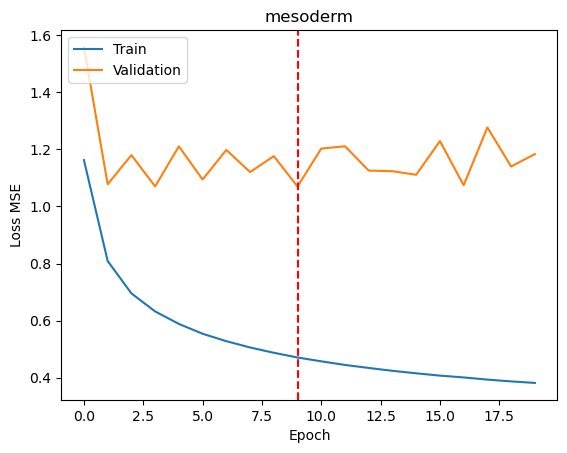

In [13]:
with open(train_val_curve_path, 'rb') as f:
    loss_data = pickle.load(f)
    train_epoch_loss = loss_data['train_epoch_loss']
    val_epoch_loss = loss_data['val_epoch_loss'][1:]

# Plot training & validation training metrics
# MSE
plt.plot(train_epoch_loss)
plt.plot(val_epoch_loss)
plt.title(task) # loss is Mean Squared Error (MSE)
plt.ylabel('Loss MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Add vertical line at minimum validation loss
min_val_loss = min(val_epoch_loss)
plt.axvline(x=val_epoch_loss.index(min_val_loss), color='red', linestyle='--')

plt.show()

# Evaluating the Model

### Model performance: mean squared error (MSE) and Pearson (PCC) and Spearman (SCC) correlation coefficients

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

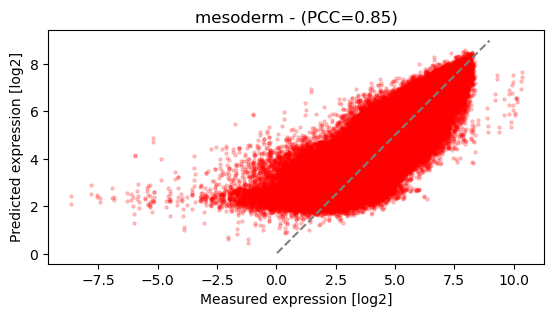

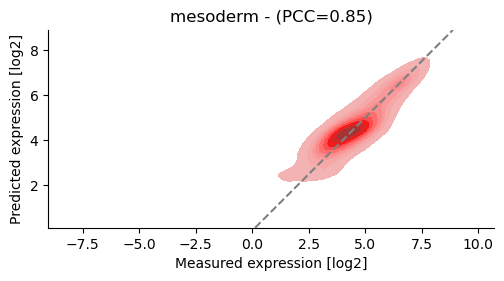

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      MSE mesoderm          0.4254334270954132
      PCC mesoderm          0.8498800992965698
      SCC mesoderm          0.8228229284286499
        test_loss           0.4254332482814789
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4254332482814789,
  'MSE mesoderm': 0.4254334270954132,
  'PCC mesoderm': 0.8498800992965698,
  'SCC mesoderm': 0.8228229284286499}]

In [14]:
best_model = DeepSTARR.load_from_checkpoint(best_model_path, params=params)
pl.Trainer().test(best_model, dataloaders=DataLoader(MyDataset(train_val_data_folder, 'train'), batch_size=params['batch_size'], collate_fn=my_collate_fn, num_workers=4, shuffle=False))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                | 0/? [00:00<?, ?it/s]

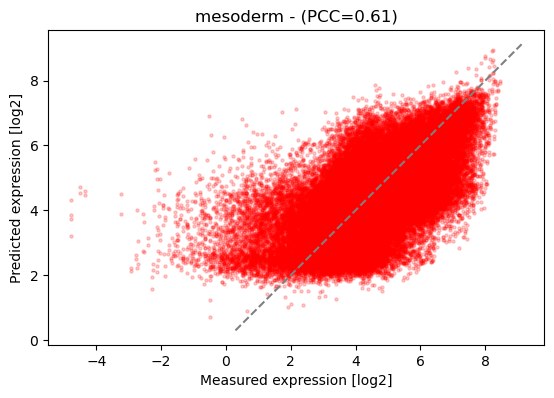

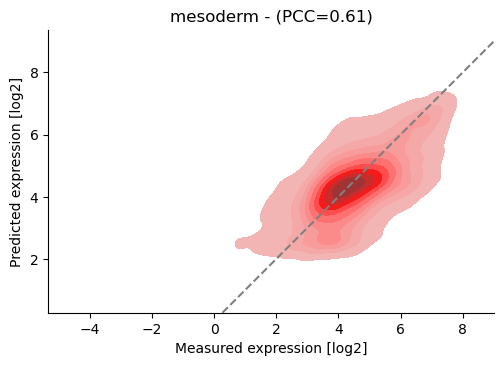

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      MSE mesoderm          1.0700937509536743
      PCC mesoderm          0.6119124293327332
      SCC mesoderm          0.5996541976928711
        test_loss           1.0700933933258057
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0700933933258057,
  'MSE mesoderm': 1.0700937509536743,
  'PCC mesoderm': 0.6119124293327332,
  'SCC mesoderm': 0.5996541976928711}]

In [15]:
best_model = DeepSTARR.load_from_checkpoint(best_model_path, params=params)
pl.Trainer().test(best_model, dataloaders=DataLoader(MyDataset(train_val_data_folder, 'val'), batch_size=params['batch_size'], collate_fn=my_collate_fn, num_workers=4, shuffle=False))